# Model Benchmarking

In this notebook, our focus is on performing multiclass classification to accurately detect and categorize the type of cyber attack. Each model is rigorously trained and tested to differentiate between various attack classes, providing us with the insight needed to identify specific threats.

We start by checking that the data is available otherwise we download it. The data is stored in a `data` folder at the root of the repository.

In [347]:
!ls dataset.zip || {wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=FILEID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V_a2wmNp3o02X2j0PONTtCCPCOn-kiJl" -O dataset.zip && rm -rf /tmp/cookies.txt}

dataset.zip


In [348]:
!ls dataset/ || unzip dataset.zip

'Network datatset'  'Physical dataset'	 preprocessed_csv   README.xlsx


# 1. Dependencies and preprocessing

Before delving into the comparative analysis of our chosen classification models, we begin by setting the foundation for our coding environment. The initial step in our notebook is to import all the necessary dependencies that will facilitate the data preprocessing, model building, visualization, and evaluation tasks. This ensures that all the tools required for our analysis are readily available and operational.

In addition to the standard libraries typically used in data science, such as numpy, pandas, scikit-learn, and matplotlib, we introduce two specialized libraries: precessing and model. The precessing library is crafted to streamline the data preprocessing phase, encapsulating functions for cleaning, normalization, feature extraction, and data splitting. Meanwhile, the model library is designed to abstract the complexity of model training and evaluation. It contains a suite of functions to instantiate, configure, and validate the performance of our Decision Tree Classifier, Random Forest, SVC, MLP, and XGBoost models.

In [349]:
import pandas as pd
import numpy as np
from preprocessing import (
    load_network_csv,
    time_split,
    load_physical_csv,
    generate_binary_labels,
    generate_sample,
)
from models import (
    generate_pipeline,
    evaluation_plot,
    evaluation_report,
    pretty_print_report,
    lof,
    isolation_forest,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier, plot_importance, plot_tree
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

We decided to use only the following files for the network part of the dataset:
- `attack1.csv`
- `attack2.csv`
- `attack3.csv`

The reason is that the other files are too big and would take too much time to process. In the attack files we already have a lot of normal labels, so we decided to use only these files.

In [350]:
network_path_list = [
    "dataset/Network datatset/csv/attack_1.csv",
    "dataset/Network datatset/csv/attack_2.csv",
    "dataset/Network datatset/csv/attack_3.csv",
]
phy_path_list = [
    "dataset/Physical dataset/phy_att_1.csv",
    "dataset/Physical dataset/phy_att_2.csv",
    "dataset/Physical dataset/phy_att_3.csv",
    "dataset/Physical dataset/phy_norm.csv",
]

We start by splitting the data into train and test sets. We use the `train_test_split` function from `sklearn` with a test size of 0.2. But in addition to that, we divided by time. We used the first 80% of the data for training and the last 20% for testing. This is because the data is ordered by time and we want to avoid having data from the future in the training set.

We decided to downsample the entire dataset around 100_000 samples. This is because the dataset is too big and it would take too much time to train the models. We will retrain the model with most promising results on the entire dataset.

In [351]:
df_network = load_network_csv(network_path_list)
df_network.value_counts("label")


label
normal    9851133
DoS       3766586
MITM      1684070
Name: count, dtype: int64

In [352]:
df_network = generate_sample(df_network, 300_000)
df_network.value_counts("label")

label
normal    193161
DoS        73854
MITM       33021
Name: count, dtype: int64

We kept the same ratio between the different classes in order to avoid biasing the models.

In [353]:
X_train_network, X_test_network, y_train_network, y_test_network = time_split(
    df_network, 0.2
)

We start by transforming the data with OneHoteEncoder, SimpleImputer and StandardScaler.

In [354]:
pipeline = generate_pipeline()

In [355]:
pipeline.fit(X_train_network)

Pipeline(steps=[('tablevectorizer', TableVectorizer()),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [356]:
X_train_network = pipeline.transform(X_train_network)

In [357]:
X_train_network.shape

(240028, 15)

We apply the same transformations to the test set.

In [358]:
X_test_network = pipeline.transform(X_test_network)

In [359]:
X_test_network.shape

(60008, 15)

Data is clearly imbalanced, so we use SMOTE to balance the data with oversampling on the training set.

In [360]:
smote = SMOTE(random_state=42)
X_train_network, y_train_network = smote.fit_resample(X_train_network, y_train_network)

In [361]:
y_train_network.shape

(423609,)

Preprocessing is done in the `preprocessing.py` file. We decided to use the following preprocessing steps:
- Remove the `Timestamp` column
- Remove data such as ip and mac addresses
- Exploratory data analysis showed some correlation, so we decided to drop `n_pkt_src` and keept only `n_pkt_dst`

Other preprocessing step are described in the `preprocessing.py` file.

In [362]:
df_network.head()

,Time,sport,dport,proto,flags,size,modbus_fn,n_pkt_dst,label
0,2021-04-09 18:23:28.385003,56667.0,502.0,Modbus,11000.0,66,Read Coils Request,0.0,normal
50,2021-04-09 18:23:28.406447,502.0,56668.0,Modbus,11000.0,65,Read Holding Registers Response,24.0,normal
102,2021-04-09 18:23:28.430467,502.0,56666.0,Modbus,11000.0,65,Read Holding Registers Response,50.0,normal
153,2021-04-09 18:23:28.454544,502.0,56668.0,Modbus,11000.0,65,Read Holding Registers Response,49.0,normal
204,2021-04-09 18:23:28.478110,56668.0,502.0,Modbus,11000.0,66,Read Holding Registers,15.0,normal


We repeat exactly the same process for the physical data, but we decided to keep the entire dataset.

Preprocessing is done in the `preprocessing.py` file. We decided to use the following preprocessing steps:
- Remove the `timestamp` column
- Encode boolean values as 0 and 1
- Convert object columns to numerical values

In [363]:
df_physical = load_physical_csv(phy_path_list)
X_train_physical, X_test_physical, y_train_physical, y_test_physical = time_split(
    df_physical, 0.2
)

We apply the same transformation as the network dataset on train and test split.

In [364]:
pipeline = generate_pipeline()

In [365]:
pipeline.fit(X_train_physical, y_train_physical)

Pipeline(steps=[('tablevectorizer', TableVectorizer()),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [366]:
X_train_physical = pipeline.transform(X_train_physical)

In [367]:
X_test_physical = pipeline.transform(X_test_physical)

In [368]:
df_physical.head()

,Time,Tank_1,Tank_2,Tank_3,Tank_4,Tank_5,Tank_6,Tank_7,Tank_8,Pump_1,...,Valv_14,Valv_15,Valv_16,Valv_17,Valv_18,Valv_19,Valv_20,Valv_21,Valv_22,label
0,2021-04-09 18:23:28,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,normal
1,2021-04-09 18:23:29,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,normal
2,2021-04-09 18:23:30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,normal
3,2021-04-09 18:23:31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,normal
4,2021-04-09 18:23:32,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,normal


# 2. Model Benchmark on Network Dataset

The primary objective of this notebook is to conduct a thorough comparison of five distinct classification models to determine their effectiveness in the context of attack classification.

## 2.1 Decision Tree Classifier

Decision Tree Classifier is an intuitive model that simulates human decision-making behavior using a tree-like model of decisions and their possible consequences.

In [369]:
decision_tree_clf = DecisionTreeClassifier(random_state=42)
decision_tree_clf.fit(X_train_network, y_train_network)

DecisionTreeClassifier(random_state=42)

In [370]:
dt_preds = decision_tree_clf.predict(X_test_network)

In [371]:
report = evaluation_report(y_test_network, dt_preds)

In [372]:
pretty_print_report(report)


    Accuracy:           0.9006965737901613
    Balanced Accuracy:  0.5469517281003816
    Precision:          0.8514165842407225
    Recall:             0.9006965737901613
    F1 Score:           0.8707748590496133
    MCC:                0.49353492476440597
    


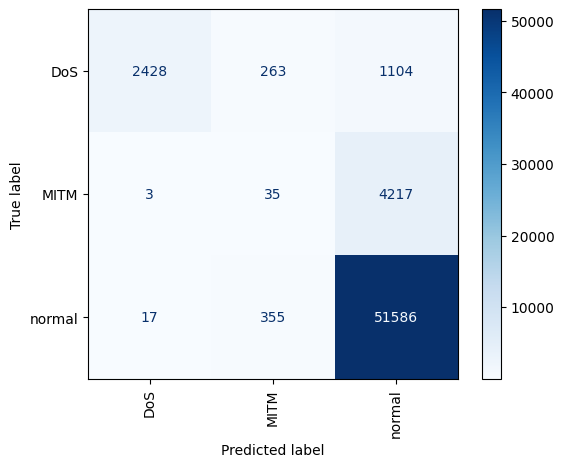

In [373]:
evaluation_plot(y_test_network, dt_preds, decision_tree_clf.classes_)

## 2.2 Random Forest Classifier

Random Forest is an ensemble learning method that constructs a multitude of decision trees at training time and outputs the class that is the mode of the classes of the individual trees.

In [374]:
rf_clf = RandomForestClassifier(max_depth=10, n_estimators=30, random_state=42)
rf_clf.fit(X_train_network, y_train_network)

RandomForestClassifier(max_depth=10, n_estimators=30, random_state=42)

In [375]:
rf_preds = rf_clf.predict(X_test_network)

In [376]:
report = evaluation_report(y_test_network, rf_preds)
pretty_print_report(report)


    Accuracy:           0.8983968804159446
    Balanced Accuracy:  0.538643692114472
    Precision:          0.8499880485849458
    Recall:             0.8983968804159446
    F1 Score:           0.8669433282896161
    MCC:                0.4757138526150829
    


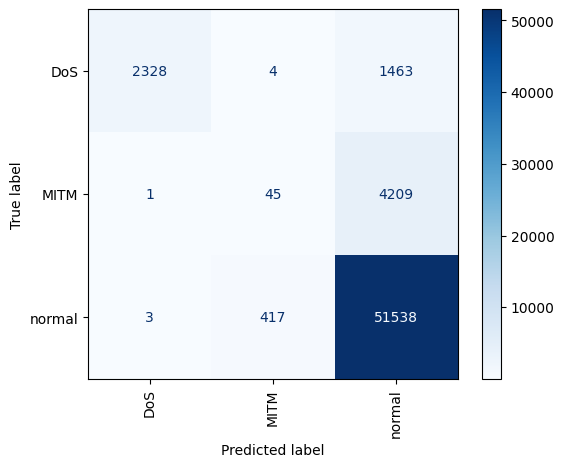

In [377]:
evaluation_plot(y_test_network, rf_preds, rf_clf.classes_)

## 2.3 BalancedRandomForestClassifier

A balanced random forest randomly under-samples each bootstrap sample to balance it.

In [378]:
brf_clf = BalancedRandomForestClassifier(max_depth=10, n_estimators=30, random_state=42)
brf_clf.fit(X_train_network, y_train_network)

/home/h/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/h/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


BalancedRandomForestClassifier(max_depth=10, n_estimators=30, random_state=42)

In [379]:
brf_preds = brf_clf.predict(X_test_network)

In [380]:
report = evaluation_report(y_test_network, brf_preds)
pretty_print_report(report)


    Accuracy:           0.8961471803759499
    Balanced Accuracy:  0.5373420238229105
    Precision:          0.8485628369488367
    Recall:             0.8961471803759499
    F1 Score:           0.8657712530280628
    MCC:                0.46163051315023873
    


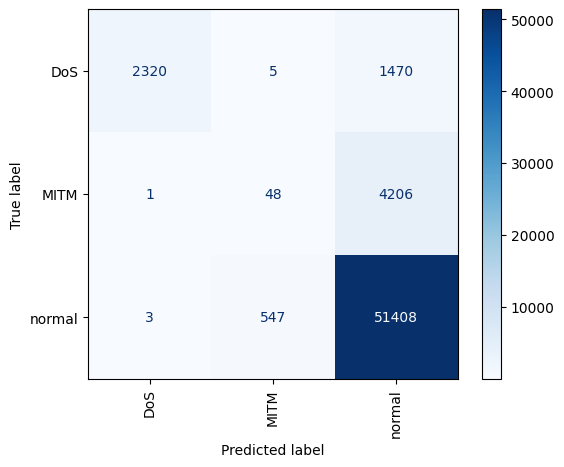

In [381]:
evaluation_plot(y_test_network, brf_preds, brf_clf.classes_)

## 2.4 Support Vector Machine (SVC) Classifier

Svm is a powerful, non-probabilistic binary linear classifier that uses a technique called kernel trick to transform the data and then based on these transformations it finds an optimal boundary between the possible outputs.

In [382]:
svc = LinearSVC(random_state=42, max_iter=400)
svc_pipeline = svc.fit(X_train_network, y_train_network)

/home/h/.local/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/h/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [383]:
svc_preds = svc.predict(X_test_network)

In [384]:
report = evaluation_report(y_test_network, svc_preds)
pretty_print_report(report)


    Accuracy:           0.8830822556992401
    Balanced Accuracy:  0.48920082908705825
    Precision:          0.8457246331149618
    Recall:             0.8830822556992401
    F1 Score:           0.8560768180051762
    MCC:                0.37985234583405414
    


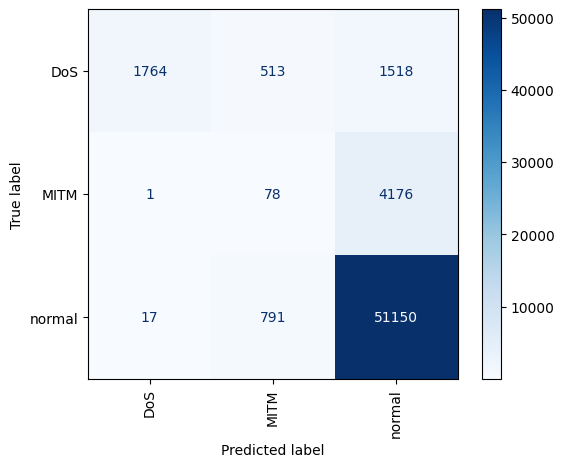

In [385]:
evaluation_plot(y_test_network, svc_preds, svc.classes_)

## 2.5 XGBoost Classifier

XGBClassifier is a highly efficient and scalable implementation of gradient boosted trees designed for speed and performance.

In [386]:
label_encoder = LabelEncoder()
y_train_network_encoded = label_encoder.fit_transform(y_train_network)

In [387]:
xgb = XGBClassifier(max_depth=10, random_state=42)
xgb_pipeline = xgb.fit(X_train_network, y_train_network_encoded) # Xgbost requires label encoding

In [388]:
xgb_preds = xgb.predict(X_test_network)

In [389]:
xgb_preds = label_encoder.inverse_transform(xgb_preds) # Inverse the label encoding

In [390]:
report = evaluation_report(y_test_network, xgb_preds)
pretty_print_report(report)


    Accuracy:           0.8991967737634982
    Balanced Accuracy:  0.539697945219127
    Precision:          0.8490386604716864
    Recall:             0.8991967737634982
    F1 Score:           0.8671483687464793
    MCC:                0.48115000486099074
    


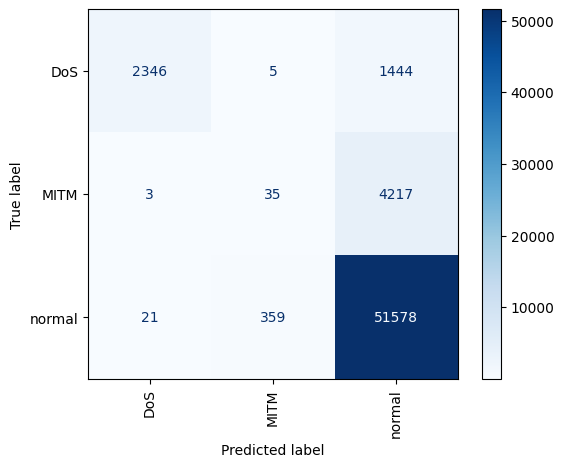

In [391]:
evaluation_plot(y_test_network, xgb_preds, label_encoder.classes_)

We can now plot feature importance for XGBoost Classifier.

# 2.6 Unsupervised - Local outlier factor (LOF)

We now go with unsupervised learning. We use the Local Outlier Factor algorithm to detect outliers in the dataset. We use the function defined in the `model.py` file.

Firstly, we define a function to plot the results of the LOF and Isolation Forest algorithms. We use a PCA to reduce the dimensionality of the data to 3 dimensions, because it is easier to visualize.

In [392]:
def plot_prediction(predictions : np.ndarray, y_true : np.ndarray, X : np.ndarray) -> None:
    """
    3D Plot the predictions of the model and the true labels
    
    Args:
        predictions (np.ndarray): The predictions of the model
        y_true (np.ndarray): The true labels
        X (np.ndarray): The training data
    """
    
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)

    # subplots 1 row, 2 columns
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.set_title("Predictions")
    ax.scatter(
        X[:, 0],
        X[:, 1],
        X[:, 2],
        c=predictions,
        cmap="Blues",
        alpha=0.5,
    )
    ax = fig.add_subplot(1, 2, 2, projection="3d")
    ax.set_title("True labels")
    ax.scatter(
        X[:, 0],
        X[:, 1],
        X[:, 2],
        c=y_true,
        cmap="Blues",
        alpha=0.5,
    )
    

In [393]:
y_encoded = y_test_network.apply(lambda x: 0 if x == "normal" else 1)

LOF Contamination: 0.01

    Accuracy:           0.863734835355286
    Balanced Accuracy:  0.5112176676862034
    Precision:          0.8048781088087082
    Recall:             0.863734835355286
    F1 Score:           0.809626093869275
    MCC:                0.07678929355239908
    



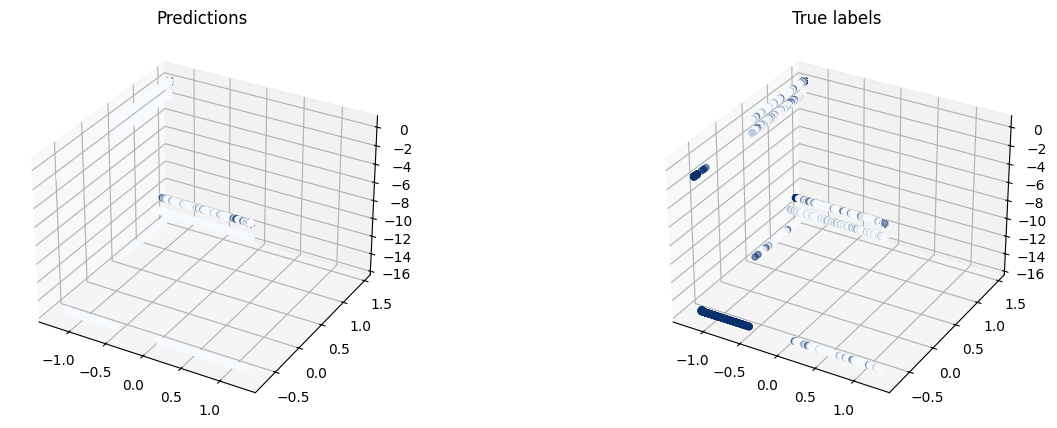

LOF Contamination: 0.02

    Accuracy:           0.8641347820290628
    Balanced Accuracy:  0.527825080410145
    Precision:          0.8167314009826825
    Recall:             0.8641347820290628
    F1 Score:           0.8180412308790026
    MCC:                0.13542678253387694
    



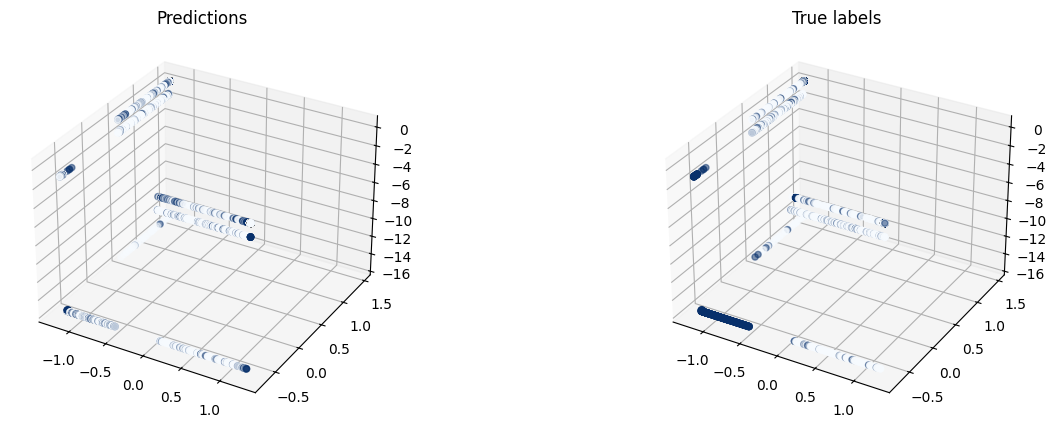

LOF Contamination: 0.03

    Accuracy:           0.8627349686708439
    Balanced Accuracy:  0.5405588053800741
    Precision:          0.8182188208039042
    Recall:             0.8627349686708439
    F1 Score:           0.8230909170618419
    MCC:                0.1620297787236074
    



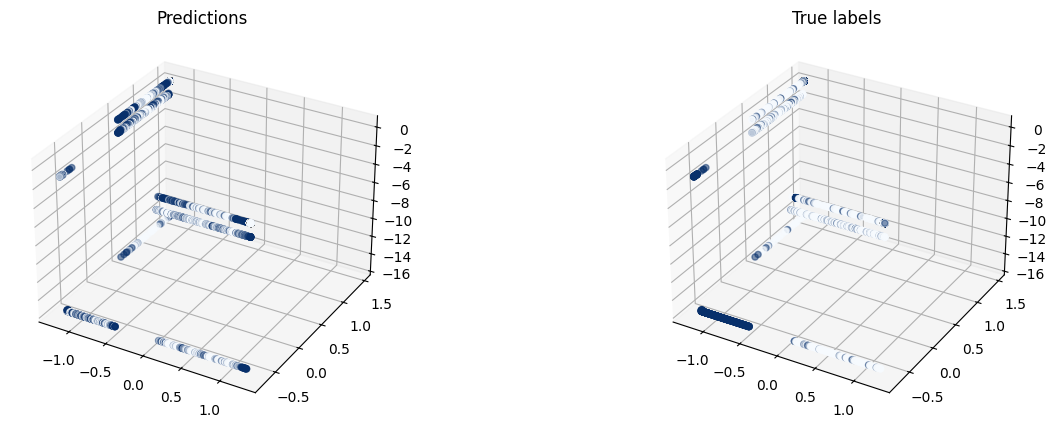

LOF Contamination: 0.05

    Accuracy:           0.8605185975203307
    Balanced Accuracy:  0.5585422578532733
    Precision:          0.8210510406221083
    Recall:             0.8605185975203307
    F1 Score:           0.8289327270996002
    MCC:                0.1935984428942096
    



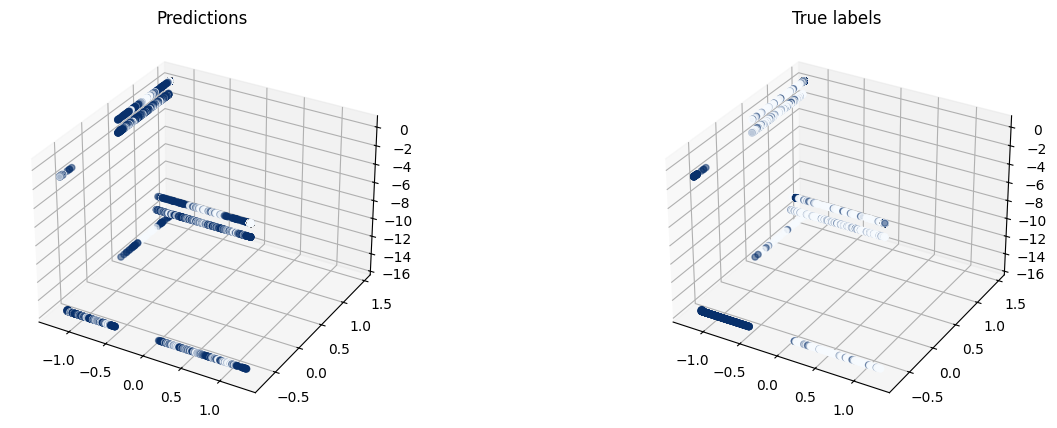

In [394]:
for contamination in [0.01, 0.02, 0.03 , 0.05]:
    lof_preds = lof(X_test_network, contamination=contamination)
    print(f"LOF Contamination: {contamination}")
    report = evaluation_report(y_encoded, lof_preds)
    pretty_print_report(report)
    print()
    plot_prediction(lof_preds, y_encoded, X_test_network)
    plt.show()

## Unsupervised - 2.7 Isolation Forest

Then we use the Isolation Forest algorithm to detect outliers in the dataset. We use the function defined in the `model.py` file. We plot the results using the function defined above. Same approach as for LOF, we have tried different values for the contamination parameter.

In [395]:
y_encoded = y_test_network.apply(lambda x: 0 if x == "normal" else 1)

Isolation Forest Contamination: 0.01

    Accuracy:           0.8680175976536462
    Balanced Accuracy:  0.5203568768754696
    Precision:          0.8354899568908963
    Recall:             0.8680175976536462
    F1 Score:           0.8155685280036675
    MCC:                0.13969630863037394
    



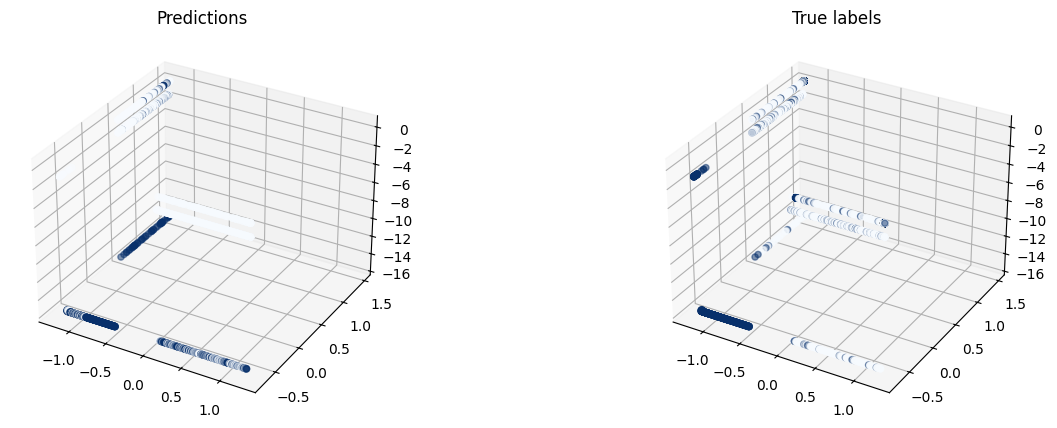

Isolation Forest Contamination: 0.02

    Accuracy:           0.865801226503133
    Balanced Accuracy:  0.5314118283305269
    Precision:          0.8230524598276466
    Recall:             0.865801226503133
    F1 Score:           0.8202730322910106
    MCC:                0.1528837574449108
    



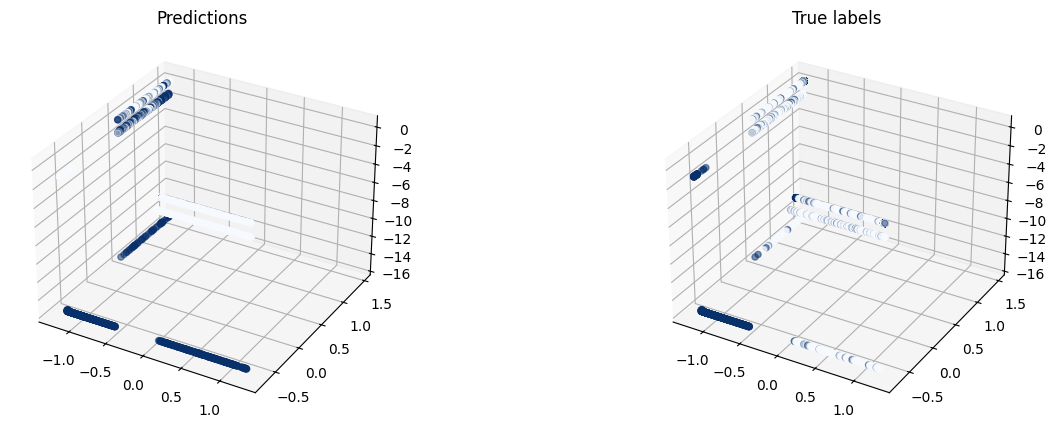

Isolation Forest Contamination: 0.03

    Accuracy:           0.862285028662845
    Balanced Accuracy:  0.5394591618313789
    Precision:          0.8169623441568994
    Recall:             0.862285028662845
    F1 Score:           0.8224568271369549
    MCC:                0.1578492701290467
    



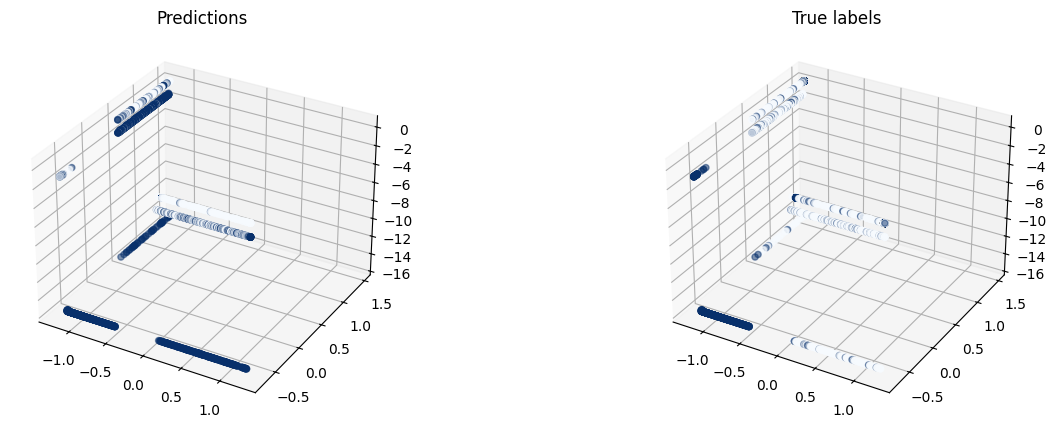

Isolation Forest Contamination: 0.05

    Accuracy:           0.8679842687641648
    Balanced Accuracy:  0.5821692532836483
    Precision:          0.8370612111225317
    Recall:             0.8679842687641648
    F1 Score:           0.8405178154123936
    MCC:                0.2588068919815316
    



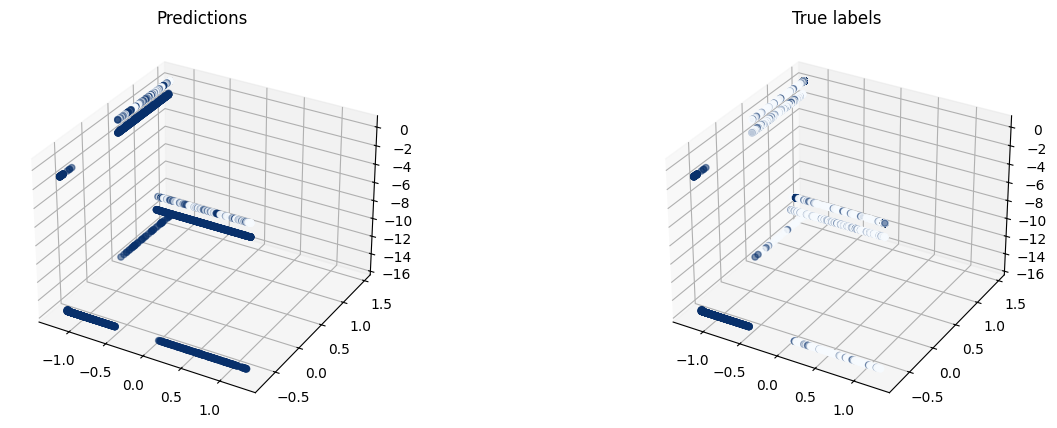

In [396]:
for contamination in [0.01, 0.02, 0.03 , 0.05]:
    if_preds = isolation_forest(X_test_network, contamination=contamination)
    print(f"Isolation Forest Contamination: {contamination}")
    report = evaluation_report(y_encoded, if_preds)
    pretty_print_report(report)
    print()
    plot_prediction(if_preds, y_encoded, X_test_network)
    plt.show()

## 2.8 Network Dataset Outcomes

This comparative study is expected to yield insightful results that will guide us in selecting the most suitable model for attack classification based on performance metrics. y applying each model to the same test data, we aim to highlight their strengths and weaknesses in a controlled environment, providing a nuanced understanding of their applicability in real-world scenarios.

From the results, we can see:

- Most of the models work about the same. The key to picking the best one is looking at balanced accuracy and the Matthew correlation coefficient. Some models handle uneven data better than others.
- How we prepare the data and deal with data that's not evenly spread out is more important than the type of model we choose.
- The Decision Tree Classifier is the best choice. It works as well as the others but is faster and doesn't use as much computer memory.
- Unsupervised methods, like detecting outliers, did a good job too. But since we were only looking at two types of labels, we should be careful about how we interpret what the model is telling us

# 3. Model Benchmark on Physical Dataset

We now reuse the same models on the physical dataset. The preprocessing is done in the `preprocessing.py` file and we reuse the transformations pipeline that we used for the network dataset.

## 3.1 Decision Tree Classifier

In [397]:
decision_tree_clf = DecisionTreeClassifier(max_depth=10, random_state=42)
decision_tree_clf.fit(X_train_physical, y_train_physical)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [398]:
dt_preds = decision_tree_clf.predict(X_test_physical)

In [399]:
report = evaluation_report(y_test_physical, dt_preds)
pretty_print_report(report)


    Accuracy:           0.9204819277108434
    Balanced Accuracy:  0.852346721255111
    Precision:          0.9435313592446205
    Recall:             0.9204819277108434
    F1 Score:           0.9288581471935419
    MCC:                0.5682482062712854
    


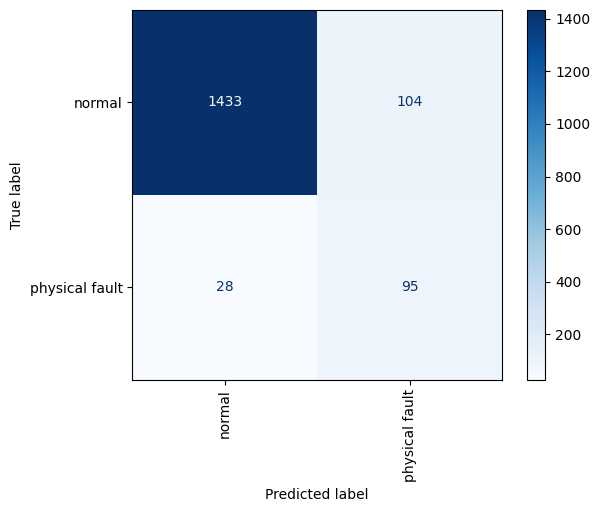

In [400]:
evaluation_plot(y_test_physical, dt_preds, decision_tree_clf.classes_)

## 3.2 Random Forest Classifier

In [401]:
rf_clf = RandomForestClassifier(max_depth=10, n_estimators=30, random_state=42)
rf_clf.fit(X_train_physical, y_train_physical)

RandomForestClassifier(max_depth=10, n_estimators=30, random_state=42)

In [402]:
rf_preds = rf_clf.predict(X_test_physical)

In [403]:
report = evaluation_report(y_test_physical, rf_preds)
pretty_print_report(report)


    Accuracy:           0.9006024096385542
    Balanced Accuracy:  0.6321865528349493
    Precision:          0.8994811062431545
    Recall:             0.9006024096385542
    F1 Score:           0.9000372993798762
    MCC:                0.26739653723329876
    


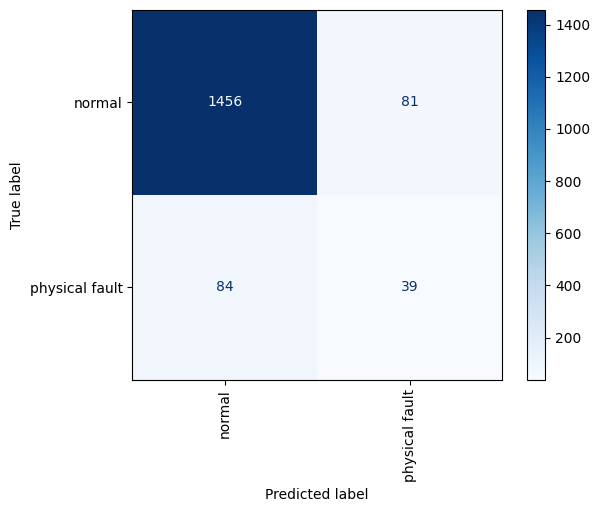

In [404]:
evaluation_plot(y_test_physical, rf_preds, rf_clf.classes_)

## 3.3 BalancedRandomForestClassifier

In [405]:
brf_clf = BalancedRandomForestClassifier(max_depth=10, n_estimators=30, random_state=42)
brf_clf.fit(X_train_physical, y_train_physical)

/home/h/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/h/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


BalancedRandomForestClassifier(max_depth=10, n_estimators=30, random_state=42)

In [406]:
brf_preds = brf_clf.predict(X_test_physical)

In [407]:
report = evaluation_report(y_test_physical, brf_preds)
pretty_print_report(report)


    Accuracy:           0.8740963855421687
    Balanced Accuracy:  0.6664894658055234
    Precision:          0.9014621105258844
    Recall:             0.8740963855421687
    F1 Score:           0.8861690416780698
    MCC:                0.27394966716411956
    


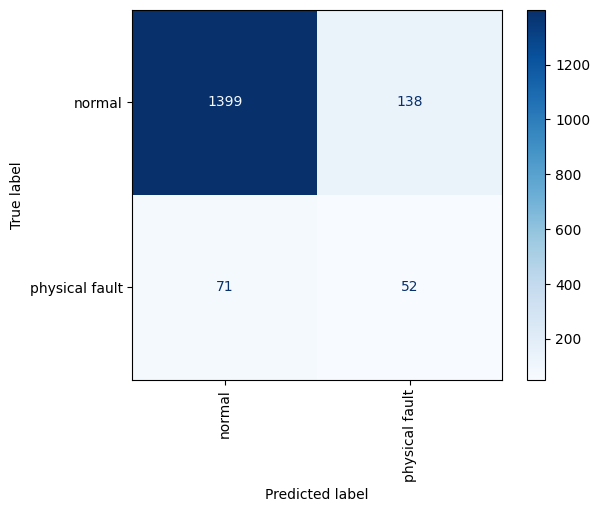

In [408]:
evaluation_plot(y_test_physical, brf_preds, brf_clf.classes_)

## 3.4 Support Vector Machine (SVC) Classifier

In [409]:
svc = LinearSVC(random_state=42, max_iter=1000)
svc.fit(X_train_physical, y_train_physical)

/home/h/.local/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(random_state=42)

In [410]:
svc_preds = svc.predict(X_test_physical)

In [411]:
report = evaluation_report(y_test_physical, svc_preds)
pretty_print_report(report)


    Accuracy:           0.6897590361445783
    Balanced Accuracy:  0.6753971150641891
    Precision:          0.9015763047620726
    Recall:             0.6897590361445783
    F1 Score:           0.76321788140933
    MCC:                0.19485407160205717
    


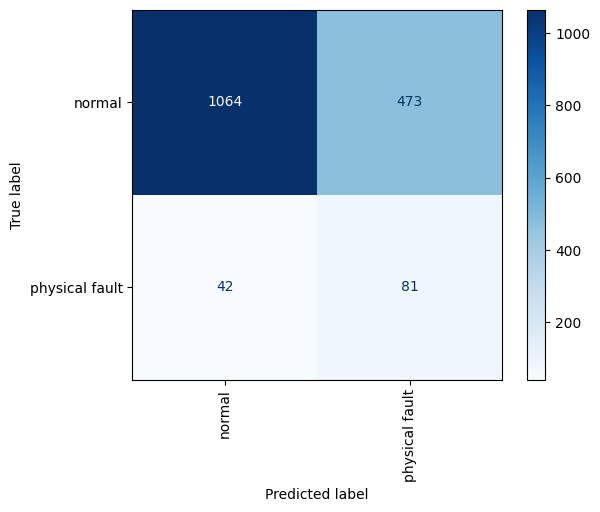

In [412]:
evaluation_plot(y_test_physical, svc_preds, svc.classes_)

## 3.5 XGBoost Classifier

In [413]:
label_encoder = LabelEncoder()
y_train_physical_encoded = label_encoder.fit_transform(y_train_physical)

In [414]:
xgb = XGBClassifier(max_depth=10, n_estimators=30, random_state=42)
xgb.fit(X_train_physical, y_train_physical_encoded) # Xgbost requires label encoding

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [415]:
xgb_preds = xgb.predict(X_test_physical)

In [416]:
report = evaluation_report(y_test_physical, label_encoder.inverse_transform(xgb_preds))
pretty_print_report(report)


    Accuracy:           0.8801204819277109
    Balanced Accuracy:  0.8417702101549318
    Precision:          0.9359231680068298
    Recall:             0.8801204819277109
    F1 Score:           0.8996773279420832
    MCC:                0.48369823817912366
    


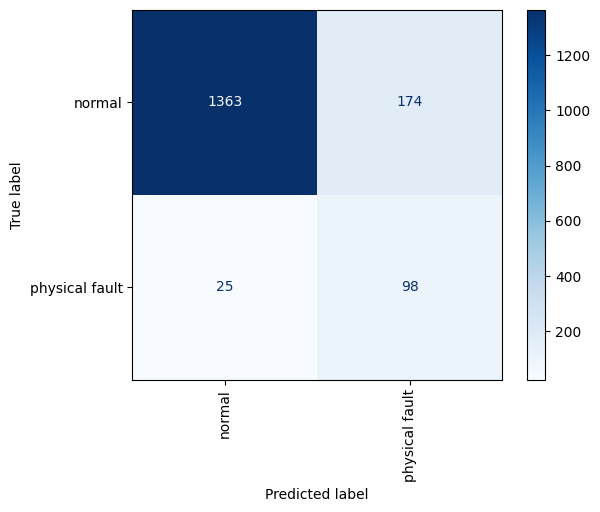

In [417]:
evaluation_plot(y_test_physical, label_encoder.inverse_transform(xgb_preds), label_encoder.classes_)

## 3.6 Local outlier factor (LOF)

In [418]:
y_encoded = y_test_physical.apply(lambda x: 0 if x == "normal" else 1)

We repeat the same process as for the network dataset.

LOF Contamination: 0.01

    Accuracy:           0.9253012048192771
    Balanced Accuracy:  0.5295925438109294
    Precision:          0.8959648842047508
    Recall:             0.9253012048192771
    F1 Score:           0.8982673551348251
    MCC:                0.1539779530708835
    



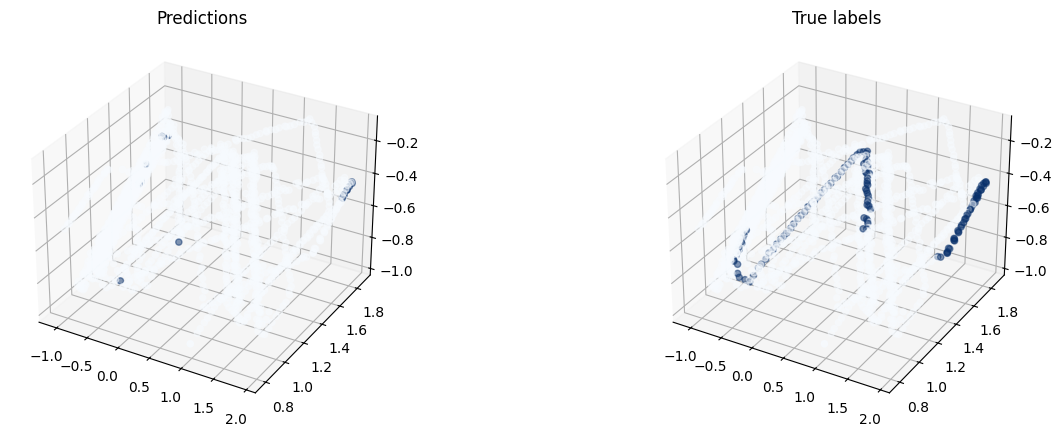

LOF Contamination: 0.02

    Accuracy:           0.9150602409638554
    Balanced Accuracy:  0.5240622900698753
    Precision:          0.8778528701304021
    Recall:             0.9150602409638554
    F1 Score:           0.8921799697809545
    MCC:                0.08899317757156594
    



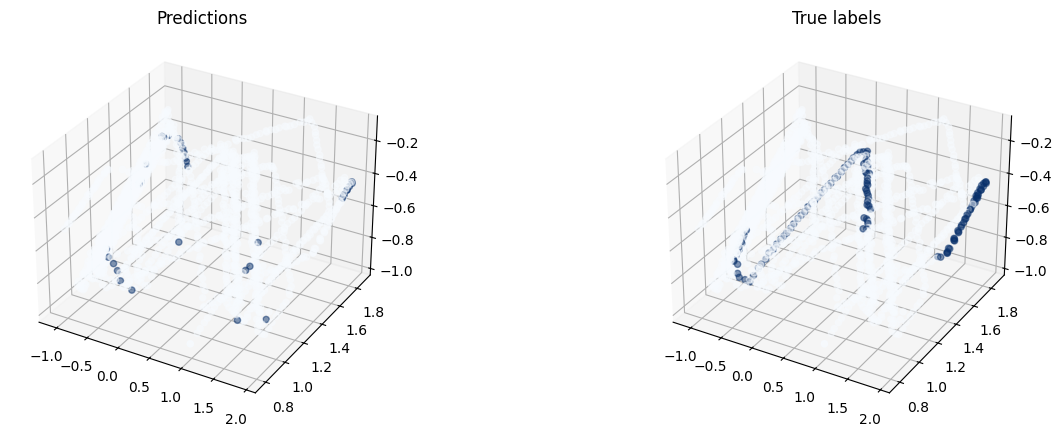

LOF Contamination: 0.1

    Accuracy:           0.8439759036144578
    Balanced Accuracy:  0.5118539441737944
    Precision:          0.8656662795761358
    Recall:             0.8439759036144578
    F1 Score:           0.8544764961698363
    MCC:                0.02069917422291624
    



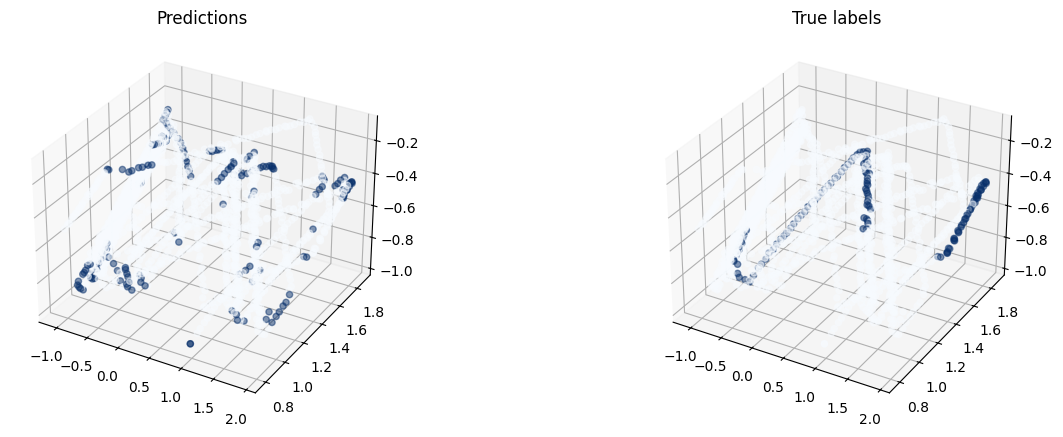

In [419]:
for contamination in [0.01, 0.02, 0.1]:
    lof_preds = lof(X_test_physical, contamination=contamination)
    print(f"LOF Contamination: {contamination}")
    report = evaluation_report(y_encoded, lof_preds)
    pretty_print_report(report)
    print()
    plot_prediction(lof_preds, y_encoded, X_test_physical)
    plt.show()

# 3.7 Isolation Forest

We repeat the same process as for the network dataset.

Isolation Forest Contamination: 0.01

    Accuracy:           0.9192771084337349
    Balanced Accuracy:  0.5076407953409398
    Precision:          0.8713541071306098
    Recall:             0.9192771084337349
    F1 Score:           0.8900631095811817
    MCC:                0.039757110235211585
    



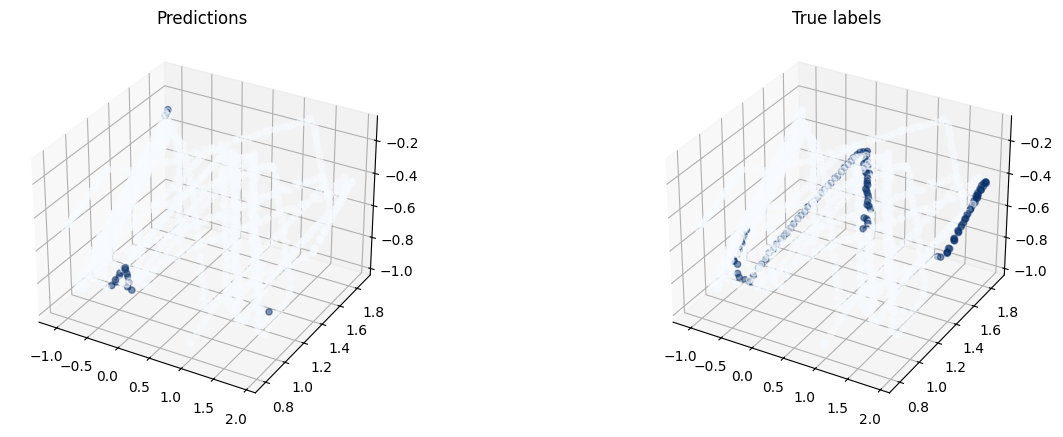

Isolation Forest Contamination: 0.02

    Accuracy:           0.9114457831325301
    Balanced Accuracy:  0.5108912409878816
    Precision:          0.8696066445072672
    Recall:             0.9114457831325301
    F1 Score:           0.8875918833886546
    MCC:                0.040280710622082716
    



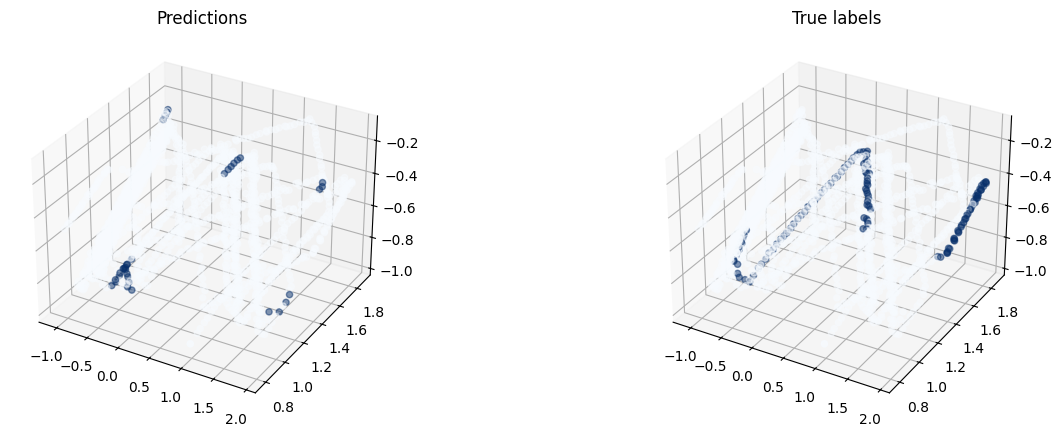

Isolation Forest Contamination: 0.03

    Accuracy:           0.9066265060240963
    Balanced Accuracy:  0.5232476950664107
    Precision:          0.8736800868068548
    Recall:             0.9066265060240963
    F1 Score:           0.8880092962315271
    MCC:                0.07125271961835852
    



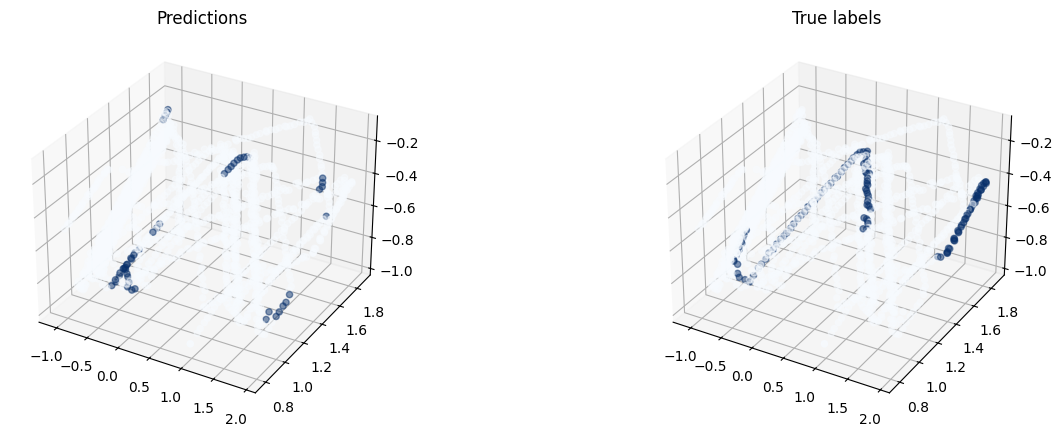

Isolation Forest Contamination: 0.1

    Accuracy:           0.8596385542168675
    Balanced Accuracy:  0.5689284901957673
    Precision:          0.879525733455912
    Recall:             0.8596385542168675
    F1 Score:           0.8690850332338682
    MCC:                0.12036186492584627
    



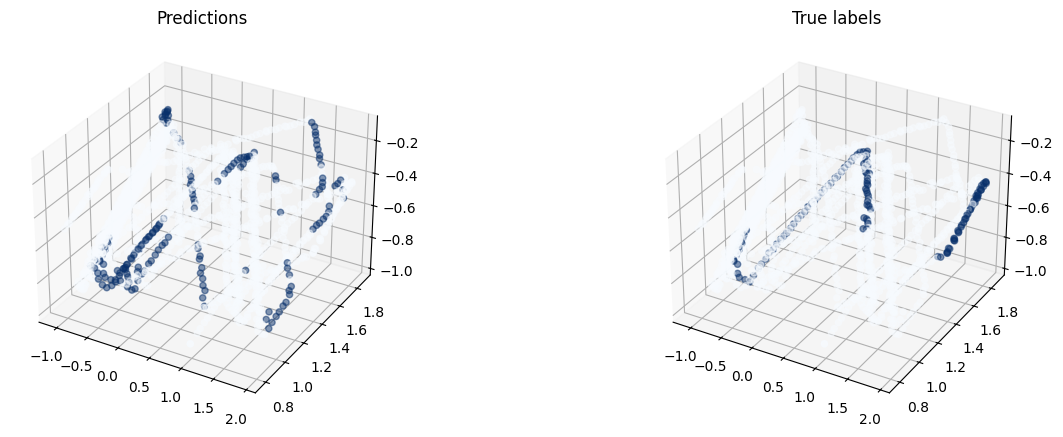

In [420]:
for contamination in [0.01, 0.02, 0.03 , 0.1]:
    if_preds = isolation_forest(X_test_physical, contamination=contamination)
    print(f"Isolation Forest Contamination: {contamination}")
    report = evaluation_report(y_encoded, if_preds)
    pretty_print_report(report)
    print()
    plot_prediction(if_preds, y_encoded, X_test_physical)
    plt.show()

# 3.8 Physical Dataset Outcomes

- Methods for finding outliers are accurate but not great at handling different types of data equally.
- Decision Trees work well and don't seem to be just memorizing the data. XGBoost is also good and can handle complex patterns.
- Methods like RandomForest and SVC didn't work too well for this task.
- Using SMOTE to balance the data only helped a little bit, so it might not be very useful for this particular dataset.

# 4. Adversarial Attacks

The goal of this section is to try to find weakness in your classifiers in order to determine if they are robust enough to be used in a real world scenario.

The idea is to look a the feature importance with the XGBoost classifier and try to find features that are important. Then we will try to change these features to see if we can fool the classifier.

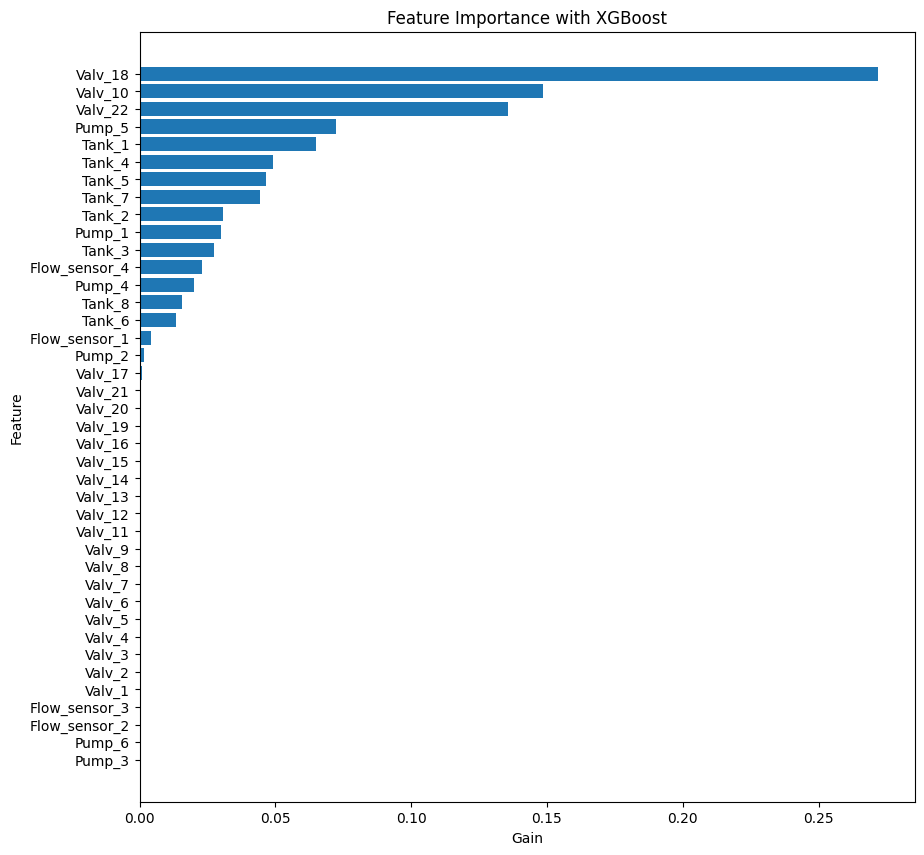

In [421]:
from xgboost import plot_importance, plot_tree


# plot feature importance with matplotlib and label of the feature with df_physical.columns without Time
sorted_features = sorted(
    zip(df_physical.columns[1:-1], xgb.feature_importances_),
    key=lambda x: x[1],
)


plt.figure(figsize=(10, 10))
plt.title("Feature Importance with XGBoost")
plt.xlabel("Gain")
plt.ylabel("Feature")
plt.barh(
    [x[0] for x in sorted_features],
    [x[1] for x in sorted_features],
);


In [422]:
xgb_preds = xgb.predict(X_test_physical)

In [423]:
report = evaluation_report(y_test_physical, label_encoder.inverse_transform(xgb_preds))
pretty_print_report(report)


    Accuracy:           0.8801204819277109
    Balanced Accuracy:  0.8417702101549318
    Precision:          0.9359231680068298
    Recall:             0.8801204819277109
    F1 Score:           0.8996773279420832
    MCC:                0.48369823817912366
    


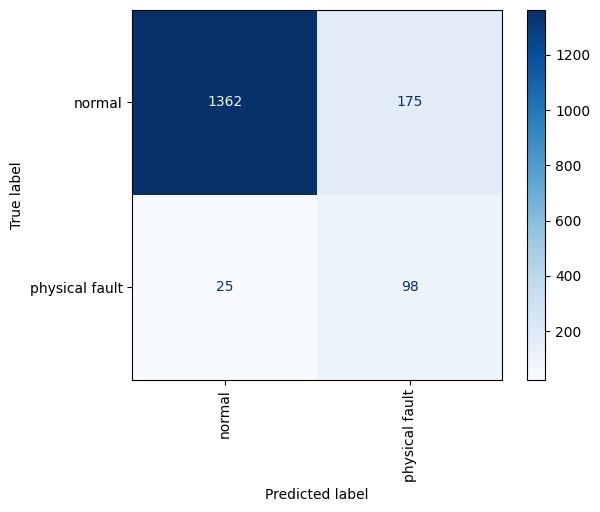

In [450]:
evaluation_plot(y_test_physical, label_encoder.inverse_transform(xgb_preds), label_encoder.classes_)

# Modifying the most important features

Your first task is to find the most important features for the XGBoost classifier. Then you will try to modify these features to see if you can fool the classifier.

In [509]:
_, X_test_physical_copy, _, _ = time_split(
    df_physical, 0.2
)

In [510]:
X_test_physical_copy.Valv_18.value_counts()

Valv_18
0    1303
1     357
Name: count, dtype: int64

In [511]:
# X_test_physical_copy.Valv_18[X_test_physical_copy.Valv_18 == 1] = 0
X_test_physical_copy.Valv_18[X_test_physical_copy.Valv_18 == 0] = 1
X_test_physical_copy.Valv_10[X_test_physical_copy.Valv_10 == 0] = 1

In [512]:
X_test_physical_copy.Valv_18.value_counts()

Valv_18
1    1660
Name: count, dtype: int64

In [515]:
dt_preds = decision_tree_clf.predict(pipeline.transform(X_test_physical_copy))

In [516]:
report = evaluation_report(y_test_physical, dt_preds)
pretty_print_report(report)


    Accuracy:           0.9204819277108434
    Balanced Accuracy:  0.852346721255111
    Precision:          0.9435313592446205
    Recall:             0.9204819277108434
    F1 Score:           0.9288581471935419
    MCC:                0.5682482062712854
    


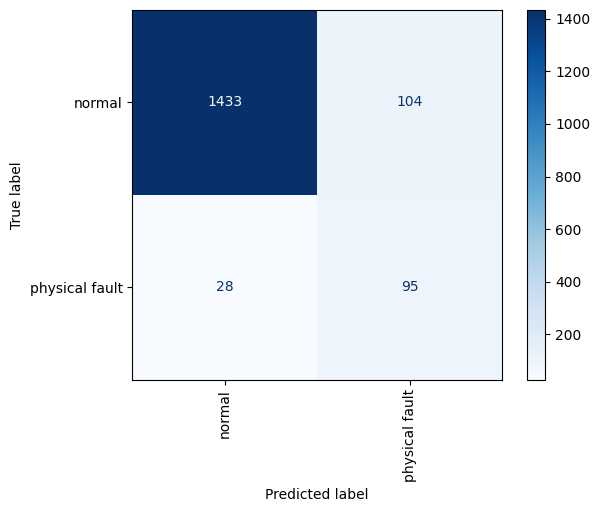

In [519]:
evaluation_plot(y_test_physical, dt_preds, decision_tree_clf.classes_)

Now your physical fault are hidden in a high number of normal data. You will have to find a way to find the most important features for the XGBoost classifier.

In [443]:
_, X_test_physical_copy, _, _ = time_split(
    df_physical, 0.2
)

In [444]:
X_test_physical_copy.Pump_6.value_counts()

Pump_6
0    976
1    684
Name: count, dtype: int64

In [445]:
X_test_physical_copy.Pump_6[X_test_physical_copy.Pump_6 == 0] = 1

In [446]:
X_test_physical_copy.Pump_6.value_counts()

Pump_6
1    1660
Name: count, dtype: int64

In [447]:
xgb_preds_pump2 = xgb.predict(pipeline.transform(X_test_physical_copy))

In [448]:
report = evaluation_report(y_test_physical, label_encoder.inverse_transform(xgb_preds_pump2))
pretty_print_report(report)


    Accuracy:           0.8801204819277109
    Balanced Accuracy:  0.8417702101549318
    Precision:          0.9359231680068298
    Recall:             0.8801204819277109
    F1 Score:           0.8996773279420832
    MCC:                0.48369823817912366
    


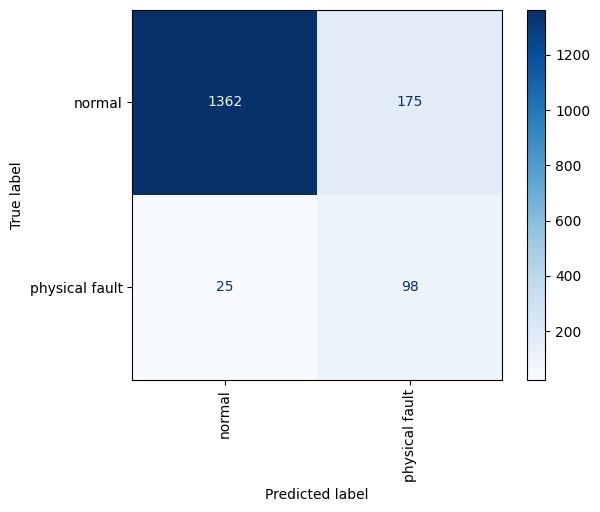

In [449]:
evaluation_plot(y_test_physical, label_encoder.inverse_transform(xgb_preds), label_encoder.classes_)

The same approach can be used with less important features.

# 4.1 Outcomes

The outcome of this section is to determine if your classifier for the physical is not really sensitive to adversarial attacks.